In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sklearn.datasets
from scipy import stats
import pymc3 as pm
%matplotlib inline

# Markov-Chain Monte Carlo, Bayesian Statistics, and PyMC

## Installation 

Before you do imports you need to install pymc3. 

`pip install pymc3`

You may need to install `arviz` as well. 

<!--
`conda install -c conda-forge pymc3`

Below are suggestions from other instructors...

N.B. There's some bad interaction between recent versions of MacOS and the back-end library Theano; doing something like

`open /Library/Developer/CommandLineTools/Packages/macOS_SDK_headers_for_macOS_10.14.pkg`

might help.

Also do `pip install arviz`
-->

## Objectives / Outline

Today we will be introducing a Monte Carlo Technique for sampling complex high dimensional probability distributions -- specifically posterior distributions associated with probabilistic models.  In order to explain MCMC and its applications in data science we will cover the following:

 * Define Monte Carlo, Markov-chain, and MCMC methods
 * Review Bayesian 
 * Describe sampling a posterior using Markov-chain Monte Carlo.
 * Build a simple model with `pymc` and calculate a trace.
 
 

### What are Monte Carlo Methods?  

**Monte Carlo Methods** are computational algorithms which rely on repeated sampling of probability distributions to solve mathematical problems numerically. 

There are several types of MC methods.  Let's start with a classic example.  

#### Monte Carlo Example 
One example is that we can use random number generators to solve for pi...

![](https://researchcomputing.syr.edu/wp-content/uploads/figure1.png)

Assuming height and width of the square is equal to 2:
$$\frac{Area_{circle}}{Area_{square}} = \frac{\pi 1^{2}}{2^2} = \frac{\pi}{4}$$

In [2]:
num_samp = 2000
x = np.random.uniform(-1,1,num_samp)
y = np.random.uniform(-1,1,num_samp)

mask = (x**2 + y**2) > 1

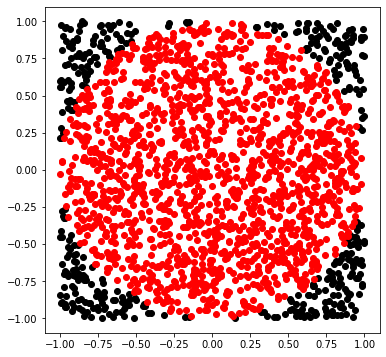

In [3]:
fig,ax = plt.subplots(figsize=(6,6))
ax.scatter(x[mask],y[mask],c='k')
ax.scatter(x[~mask],y[~mask],c='r');

In [4]:
pi = 4 * np.sum(~mask)/num_samp
pi

3.164

Monte Carlo methods are commonly used in physics, chemistry, mathematics, data science, etc. to solve problems -- sample probability distributions, integrate equations, etc.  

Today we will be talking about a specific type of monte carlo simulations: Markov Chain Monte Carlo.  Let's next define what a Markov Chain is.  

### What are Markov Chains? 

A **Markov Chain** is a stochastic model used to describe a sequence of events where the probability of the next event occuring is only dependent on your current state.  

![](markov_chains.png)


### Markov Chains Monte Carlo (MCMC) 

Putting these two concepts together MCMC are a class of simulation algorithms that are commonly used to sample *complex high dimensional probability distributions* by creating a Markov Chain of samples from a probability distribution.  

#### Metropolis-Hasting

There are a number of different approaches to MCMC; a common one is called the [Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) algorithm.  The Metropolis-Hasting algorithm pulls a sequence of points from a known probability distribution (that does not need to be normalized). 

##### Metropolis Hasting Algorithm 
It works as follows:

1. First, we start at a given point, x, in our probability distribution. 
2. Adjust the position slightly, x + $\delta x$ 
<!-- 3. If PDF(x + $\delta x$) > PDF(x): Accept the new position; go to step 1 -->
3. If a uniform random number [0,1] < $ \frac {PDF(x + \delta x)} {PDF(x)}$: Accept; got to step 1
4. Otherwise: reject; keep position x

Let's implement it and show that this process can pull points from a standard Normal distribution:

In [ ]:
def metropolis(x, num_mc_steps, step_size): # step 1: x specifies your starting point 
    """
    x: starting position for MCMC
    num_mc_steps: number of MC steps
    step_size: controls how the candidate sample is generated
    """
    points_accepted = []
    for i in range(num_mc_steps):
        # step 2
        new_pos = x + step_size*np.random.uniform(-1,1)
        # step 3
        pdfx, pdfnew = stats.norm.pdf(x),stats.norm.pdf(new_pos)
        if np.random.uniform(0,1) < pdfnew/pdfx:
            x = new_pos
            points_accepted.append(x) 
        # step 4: do nothing is equivalent to rejection
    return points_accepted


pts = metropolis(0.3, 5000, 2.0)
print(len(pts))

3141


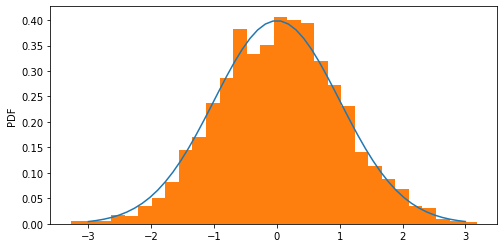

In [5]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(np.linspace(-3,3),stats.norm.pdf(np.linspace(-3,3)))
ax.hist(pts,density=True,bins=30)
ax.set_ylabel('PDF');

Let's think through the probability ratio: $\frac {PDF(x + \delta x)} {PDF(x)}$.  

1. If $\frac {PDF(x + \delta x)} {PDF(x)}$ is greater than or equal to one then the new candidate is more probable and we accept. 
2. If $\frac {PDF(x + \delta x)} {PDF(x)}$ is less than one the new candidate is less probable and we accept with a probability equivalent 

#### Practical take aways from MCMC

A few practical highlights of the Metropolis Hasting Algorithm:

1. Efficient at pulling random points from high dimensional complex probability distributions.   Probability distributions that use this algorithm do not exist in libraries like scipy.
2. It does not require that that the probability distribution is normalized -- this is challenging when PDFs are complex. 
3. While there can be many applications of the Metropolis Hasting Algorithm, we will be using it to sample models.

<!--
#### Optional Aside: Applications of MCMC 

MCMC has many cool applications for sampling <i>high dimensional</i> probability distributions.  For example, its widely used as a sampling techinique of probable chemical configurations in statistical mechanics and is also used to integrate high dimensional functions using **importance sampling**. 

$E[f(x)]=\int f(x)p(x)dx \approx \frac{1}{n} \sum_{n}^{i=1} f(x_i)$ 

where x_i are pulled from the probability distribution p(x) in the approximate integral above.  

For example, p(x) could be the probability that a customer makes a purchase and f(x) could be the amount of money they spend, x could be various characteristics of a customer, and the integral you are computing is the average money spent by customers interacting on your webpage.  
-->

### 2D Metropolis - Hasting
Let's try reimplement Metropolis-Hasting algorithm a higher dimensional case, a multivariate normal distribution. Below we will use a two dimensional distribution (because we want to draw it) centered at the origin with a variance of 1 in one direction and 2 in the other.

In [6]:
dist = stats.multivariate_normal([0, 0], [[2, 0], [0, 1]])

We also need to set up a distribution to generate new candidates:

In [7]:
# parameters are mean, and a covariance matrix
step_generator = stats.multivariate_normal([0, 0], [[0.5, 0], [0, 0.5]])

In [8]:
step_generator.rvs()

array([0.42033362, 0.5418487 ])

Below is a function for one MC step:  

In [54]:
def consider_step(dist, step_generator, accepted, rejected):
    """Make one step using the Metropolis-hastings algorithm."""
    # make previous accept point the first position or default starting point
    if len(accepted) > 0:
        current = accepted[-1][1]
    else:
        # step 1: specificies starting location
        current = np.array([4, 2])

    # step 2
    new = current + step_generator.rvs()
    # step 3
    if np.random.rand() < (dist.pdf(new) / dist.pdf(current)):
        print(f"Accept: Current pdf: {dist.pdf(current):.4f} new pdf {dist.pdf(new):.4f}")
        accepted.append((current, new))
    # step 4
    else:
        print(f"Reject: Current pdf: {dist.pdf(current):.4f} new pdf {dist.pdf(new):.4f}")
        rejected.append((current, new))

In [58]:
accepted = []
rejected = []

In [59]:
for _ in range(10):
    consider_step(dist, step_generator, accepted, rejected)

Accept: Current pdf: 0.0003 new pdf 0.0035
Accept: Current pdf: 0.0035 new pdf 0.0046
Reject: Current pdf: 0.0046 new pdf 0.0009
Accept: Current pdf: 0.0046 new pdf 0.0285
Accept: Current pdf: 0.0285 new pdf 0.0347
Reject: Current pdf: 0.0347 new pdf 0.0173
Accept: Current pdf: 0.0347 new pdf 0.0841
Accept: Current pdf: 0.0841 new pdf 0.0738
Reject: Current pdf: 0.0738 new pdf 0.0166
Reject: Current pdf: 0.0738 new pdf 0.0137


Let's graph that, along with ellipses at 1 and 2 standard deviations.

In [12]:
def plot_mcmc_steps(ax, accepted, rejected,
                    show_connections=False,
                    show_rejected=False):
    ax.plot([0], [0], 'go')

    
    if show_rejected:
        for step in rejected:
            ax.plot(*zip(step[0], step[1]), 'ro-', lw=0.5, alpha=0.3,c='red')
            
    if show_connections:
        for step in accepted:
            ax.plot(*zip(step[0], step[1]), 'go-', lw=0.5, alpha=0.3)
    else:
        for step in accepted:
            ax.plot(*zip(step[0], step[1]), 'b.', lw=0.5, alpha=0.8)

    ax.add_artist(matplotlib.patches.Ellipse(xy=(0, 0),
                                             width=4,
                                             height=2,
                                             fill=False,
                                             ec='g',
                                             lw=0.5))
    ax.add_artist(matplotlib.patches.Ellipse(xy=(0, 0),
                                             width=8,
                                             height=4,
                                             fill=False,
                                             ec='g',
                                             lw=0.5))
    ax.set_xlim(-5, 5)
    ax.set_ylim(-2.5, 2.5)

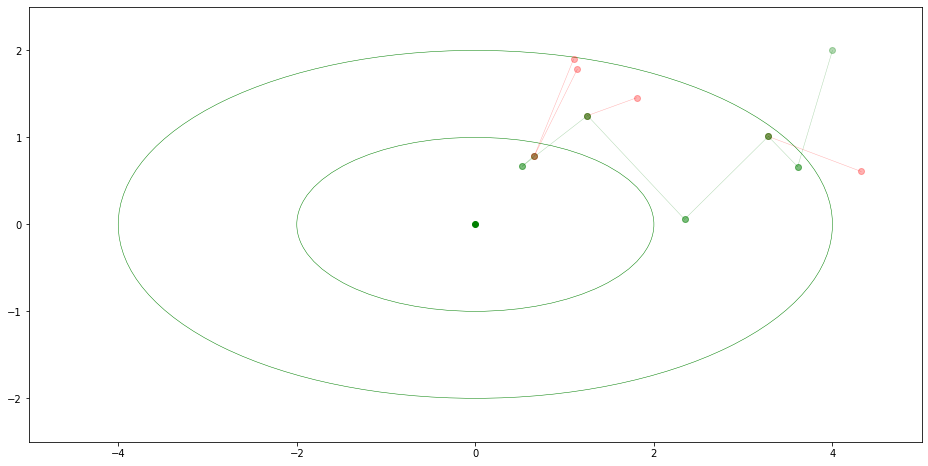

In [60]:
fig, ax = plt.subplots(figsize=(14, 6))
# we can change show_connections and show_rejected to understand the process
plot_mcmc_steps(ax, accepted, rejected,
                show_connections=True,
                show_rejected=True)

**Question:** What happens at the beginning of this MCMC trajectory 


The accepted points can be treated as an IID sample from the distribution, and then we can draw conclusions from that (e.g., what's the probability that $x_1 > 2$?)

**Question:** are the points actually IID?


### Optional Aside : Hamiltonian Monte Carlo and No-U-Turn Sampling

Today most MCMC approaches use more sophisticated algorithms, generally using a similar idea but including momentum. The `pymc3` library uses NUTS (No-U-Turn Sampling) by default.  A brief intro is at the end of this lecture as optional content

## Summary

1. If I run a MCMC algorithm (Metropolis-Hasting, HMC, or NUTS), I get back a sequence of points pulled from my probability distribution 
2. The probability distribution does not need to be normalized! 
3. MCMC is commonly used to sample high dimensionaly probability distriubtions.  

## Introduction to pymc and its applications to Bayesian Statistics 

Today we will use MCMC to help us build models.  First, we need to review bayesian statistics. 

### Review Bayesian Statistics

Earlier we talked a bit about Bayesian statistics. To review:

Suppose we're considering some hypothesis $H$ and we've collected some data $\mathbf{X}$.
$$ P(H|\mathbf{X}) = \frac{P(\mathbf{X}|H) P(H)}{P(\mathbf{X})} $$

Each term has a name.

* $P(H)$ is the *prior probability*
* $P(\mathbf{X}|H)$ is the *likelihood*.
* $P(\mathbf{X})$ is the *normalizing constant*.
* $P(H|\mathbf{X})$ is the *posterior probability*.


If there are a bunch of hypotheses $H_1, H_2, ... H_n$ (that we assume *partition* the sample space, so exactly one of them is true), we could write this as

$$\begin{align}
P(H_i|\mathbf{X}) & = \frac{P(\mathbf{X}|H_i) P(H_i)}{P(\mathbf{X})}\\
         & = \frac{P(\mathbf{X}|H_i) P(H_i)}{\sum_{j} P(\mathbf{X}|H_j) P(H_j)}
\end{align}
$$

Here we see the normalizing constant is the likelihood times the prior summed over all possible hypothesis. In other words, it's the constant (independent of hypothesis) we need to divide all the numerators by so they all add up to one.

**Computing the normalization constant is difficult!** Some approaches to deal with this are:

* Use conjugate priors (only works for simple models)
* Directly compute the summation above (impossible in high dimensional spaces)
* Random sampling via MCMC or Metropolis-Hasting where a normalized probability distribution is not required! (best for high dimensional problems 

Using MCMC, we will sample 

$$\begin{align}
P(H_i|\mathbf{X}) \propto P(\mathbf{X}|H_i) P(H_i)
\end{align}
$$

## CTR Example 

Let's start with the coin-flip/CTR example we've seem a couple times before. In this we have data on successes and failures and we want to determine the value of some unknown click-through rate. Let's state what we need to do bayesian statistics:

* prior --> uniform distribution 
* likelihood --> data we accumulate for the CTR; Bernoulli distribution
* normalization constant --> we will not need it with MCMC! 

We are sampling the posterior.

First, let's make some fake data!

In [14]:
prob_actual = 0.10
data_ctr = stats.bernoulli(prob_actual).rvs(100, random_state=10)
data_ctr

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0])

In [15]:
data_ctr.mean()

0.08

Now, let's sample the posterior! Note the following 

$$P(H_i|\mathbf{X}) \propto P(\mathbf{X}|H_i) P(H_i)$$
$$P(\mathbf{X}|H_i) = \prod_{i=1}^{100} p^{x_i} (1-p)^{1-x_i}$$
$$P(H_i) \propto 1$$

where $x_i$ is 1 if the click was successful and 0 if not. 

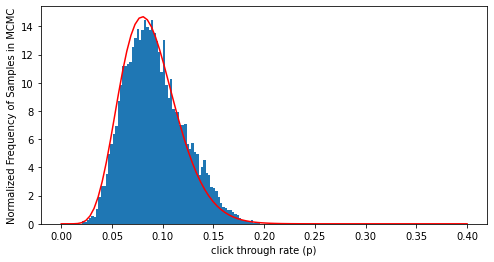

In [16]:
# get value proportional to posterior distribution based on value of p 
def get_posterior(p):
    prior = 1. # indicating all priors are the same
    likelihood = np.power(p,np.sum(data_ctr))*np.power(1-p,len(data_ctr)-np.sum(data_ctr))
    return prior*likelihood

# use MCMC to sample the posterior distribution for various values of p 
def metropolis(p, num_mc_steps, step_size):
    points_pulled = np.array([])
    for i in range(num_mc_steps):
        new_pos = p + step_size*np.random.normal(0,1)
        pdfx, pdfnew = get_posterior(p),get_posterior(new_pos)
        if np.random.uniform(0,1) < pdfnew/pdfx:
            p = new_pos
            points_pulled = np.append(points_pulled,p)
    return points_pulled

# plot 
pts = metropolis(0.08, 10000, 0.01)
fig, ax = plt.subplots(figsize=(8,4))
# plot mcmc samples
ax.hist(pts,bins=80,density=True)
# plot known beta distribution
x = np.linspace(0,0.4,100)
ax.plot(x, stats.beta(data_ctr.sum()+1,len(data_ctr)-data_ctr.sum()+1).pdf(x),c='r')
ax.set_ylabel('Normalized Frequency of Samples in MCMC')
ax.set_xlabel('click through rate (p)');


## Introduction to pymc3 

Now let's implement that same thing, but with the pymc3 library. 

The pymc interface uses the `with` statement in python to specify a model with which we'll be operating. 

Let's first demo one way a with statement is commonly used in Python. 

In [17]:
file = open('demo1.txt', 'w') 
file.write('hello world !') 
file.close() 

In [18]:
with open('demo2.txt', 'w') as file: 
    file.write('hello world !') 

The same functionality demo-ed above can be created for user defined objects ([see this link for more details](https://www.geeksforgeeks.org/with-statement-in-python/) ).  This is what PyMC does. 

The pymc interface uses the `with` statement in python to specify a model with which we'll be operating. The first time we interact with it we'll need to call the constructor and assign it to a variable with `as`; after that we just refer to that variable. Any variables created are added to that model object automatically, and any sampling or optimization is done on that model.

There are two types of variables in PyMC3: Unobserved Random Variables and Observed Random Variables.  The difference is that Observed Random variables will incorporate data via the observed flag. 

In [19]:
with pm.Model() as model_ctr:  
    pass

In [20]:
#model_ctr.basic_RVs

In [21]:
with pm.Model() as model_ctr:        # creating an instance of our model
    # Unobserved Random Variable 
    prob = pm.Uniform('prob', 0, 1)  # Prior 
    # Observed Random Variable
    observed = pm.Bernoulli('observed', prob, observed=data_ctr) # Likelihood 

In [61]:
#model_ctr.basic_RVs  # free_RVs # observed_RVs

Now we do some sampling! The result of sampling is often called a *trace*. The initial tuning steps let the algorithm figure out the optimum step size; if there isn't enough tuning the algorithm might make steps that are too big (and hence constantly rejected) or too small (and so take too long to explore the sample space).

In [23]:
with model_ctr:
    trace = pm.sample(5000, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prob]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:09<00:00, 1205.25draws/s]
The acceptance probability does not match the target. It is 0.8866469502175975, but should be close to 0.8. Try to increase the number of tuning steps.


If the `tune` parameter is set too small we will get a warning here. Simply increase the parameter and try again.

The result of `sample` will contain values for all of the variables, distributed (if we have enough) in the same manner as the posterior distribution of those variables. Let's visualize them.

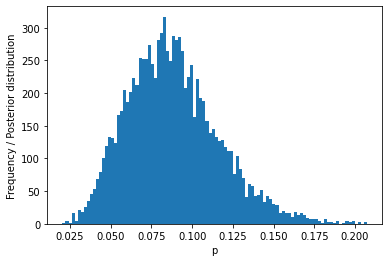

In [24]:
fig, ax = plt.subplots()
ax.hist(trace['prob'], bins=100)
ax.set_xlabel('p')
ax.set_ylabel('Frequency / Posterior distribution');

**Questions:**

Why doesn't it peak at the actual value for the probability (`prob_actual`)?

**Discussion:** Now that we have this posterior distribution of hypothesis, what can we do with it? (hint: we did this before when we talked about Bayesian statistics)

## A (slightly) harder example

Bernoulli distributions aren't all that exciting. Again, let's use fake data. We'll sample a few points from a normal distribution and try to recover the parameters.

In [63]:
mu_actual = 5
sigma_actual = 2
data = stats.norm(mu_actual, sigma_actual).rvs(30)

What do we have?

In [64]:
print("mean = {:.3f} sd = {:.3f}".format(data.mean(), data.std()))

mean = 5.249 sd = 1.911


For now let's assume we know `sigma`, just to make it easier. We'll take a uniform prior for `mu` but assume it's between 0 and 10.

In [65]:
with pm.Model() as model_normal:
    # prior
    mu = pm.Uniform("mu", 0, 10)
    # likelihood
    observed = pm.Normal("observed", mu, 2, observed=data)

We might want to start my calculating the maximum *a posteriori* (MAP) value for the `mu`.

**Question:** what is MAP?

In [66]:
with model_normal:
    estimate = pm.find_MAP()
estimate['mu']

//anaconda3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -64.596, ||grad|| = 4.6678: 100%|██████████| 6/6 [00:00<00:00, 253.97it/s]


array(5.24895082)

In [67]:
with model_normal:
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:18<00:00, 1164.93draws/s]


Text(0, 0.5, 'frequency')

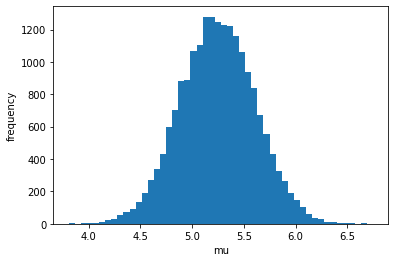

In [68]:
fig, ax = plt.subplots()
ax.hist(trace['mu'], bins=50)
ax.set_xlabel('mu');
ax.set_ylabel('frequency')

But really we want to estimate both the `mu` and `sigma`. We just need to put both in the model.

In [69]:
with pm.Model() as model_normal2:
    # prior
    mu = pm.Uniform('mu', 0, 10)
    sigma = pm.Uniform('sigma', 0, 10)
    # likelihood
    observed = pm.Normal("observed", mu, sigma, observed=data)

In [70]:
with model_normal2:
    estimate = pm.find_MAP()
print('mu:',estimate['mu'],'sigma:',estimate['sigma'])

logp = -66.607, ||grad|| = 4.7515e-06: 100%|██████████| 12/12 [00:00<00:00, 481.41it/s]  

mu: 5.2489507384391185 sigma: 1.9112868199311595


Are these the right values?

In [71]:
print("                   mu   sigma")
print("MAP estimate      {:5.3f} {:5.3f}".format(float(estimate['mu']), float(estimate['sigma'])))
print("sample statistics {:5.3f} {:5.3f}".format(data.mean(), data.std()))
print("actual            {:5.3f} {:5.3f}".format(mu_actual, sigma_actual))

                   mu   sigma
MAP estimate      5.249 1.911
sample statistics 5.249 1.911
actual            5.000 2.000


In [72]:
with model_normal2:
    trace = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:11<00:00, 1014.58draws/s]


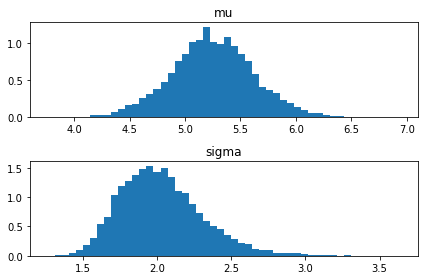

In [73]:
fig, axes = plt.subplots(2)
axes[0].hist(trace['mu'], bins=50, density=True)
axes[1].hist(trace['sigma'], bins=50, density=True)
axes[0].set_title("mu")
axes[1].set_title("sigma")
plt.tight_layout()
plt.show()

There's a function to plot this automatically.

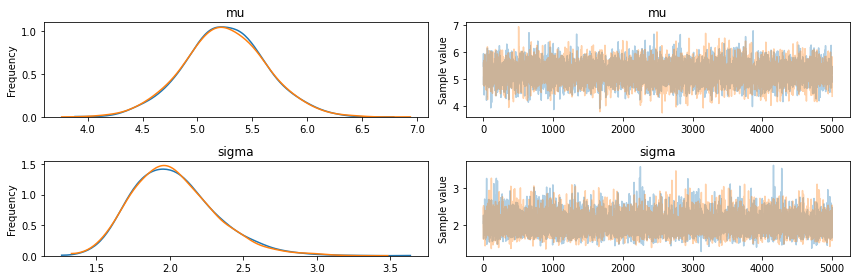

In [74]:
pm.traceplot(trace);

## Linear modeling

In this modeling we will do linear modeling from the bayesian perspective.  That is 

$$Y \propto N(mx+b, \sigma^2)$$

We have an option to assume the distributions from which $\sigma$, m and b come from by incorporating a prior.

Lets generate some data with known slope and intercept and fit a simple linear GLM.

In [75]:
size = 10
true_intercept = 1
true_slope = 2
x = np.linspace(0, 1, size)
y = true_intercept + x*true_slope + np.random.normal(scale=.5, size=size)
data = {'x': x, 'y': y}

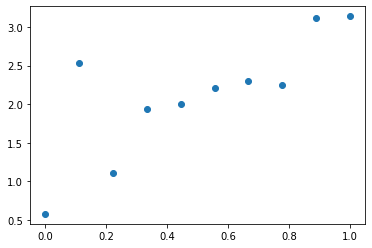

In [76]:
fig,ax = plt.subplots()
ax.scatter(x,y);

In [77]:
with pm.Model() as model:
    slope = pm.Normal('slope', 0, 100)         # prior for slope
    intercept = pm.Normal('intercept', 0, 100) # prior for intercept 
    sigma = pm.HalfNormal('sigma', 100)        # prior for noise 
    observed = pm.Normal('observed', mu=intercept + slope*x, sd=sigma, observed=y)

In [78]:
n_sample = 500
with model:
    trace = pm.sample(n_sample)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, intercept, slope]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:03<00:00, 584.64draws/s]


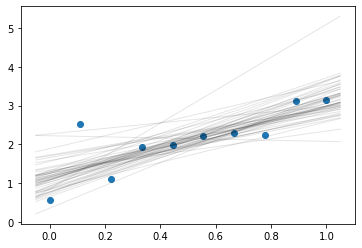

In [79]:
fig,ax = plt.subplots()
ax.scatter(x,y)
xlim = np.array(ax.get_xlim())
for i in range(0, n_sample, 10):
    ax.plot(xlim, trace[i]['intercept'] + trace[i]['slope'] * xlim,
            c='k', lw=1, alpha=0.1);

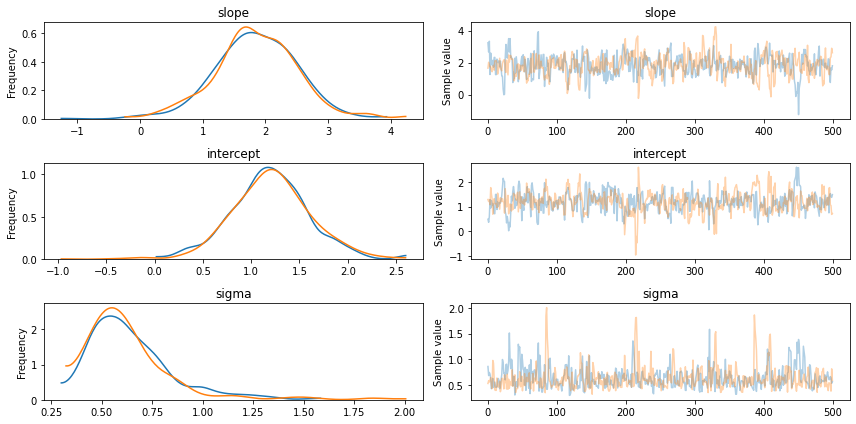

In [80]:
pm.traceplot(trace);

FYI, you can complete the process you created above with the following few lines: 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, x, Intercept]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:09<00:00, 533.92draws/s]


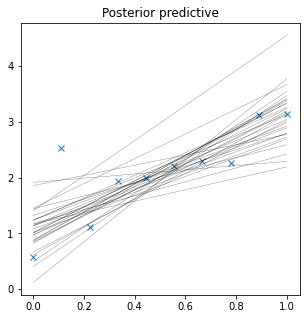

In [81]:
with pm.Model() as model:
    pm.GLM.from_formula('y ~ x', data)
    trace = pm.sample(2000, cores=2)

plt.figure(figsize=(5, 5))
plt.plot(x, y, 'x')
pm.plot_posterior_predictive_glm(trace)

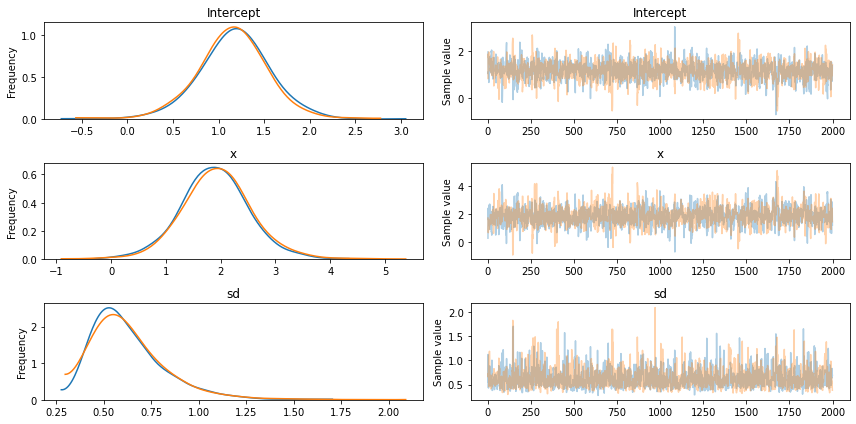

In [82]:
pm.traceplot(trace); # note x is the slope and sd is the standard deviation of error for y

### Optional Content: Robust GLM

Lets try the same model but with a few outliers in the data.

In [45]:
x_out = np.append(x, [.1, .15, .2])
y_out = np.append(y, [8, 6, 9])
data_outlier = dict(x=x_out, y=y_out)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, x, Intercept]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:08<00:00, 559.34draws/s]


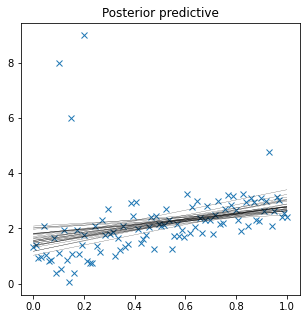

In [46]:
with pm.Model() as model:
    pm.GLM.from_formula('y ~ x', data_outlier)
    trace = pm.sample(2000, cores=2)

plt.figure(figsize=(5, 5))
plt.plot(x_out, y_out, 'x')
pm.plot_posterior_predictive_glm(trace)

Because the normal distribution does not have a lot of mass in the tails, an outlier will affect the fit strongly.

Instead, we can replace the Normal likelihood with a student T distribution which has heavier tails and is more robust towards outliers. While this could be done with the linear_compoment() function and manually defining the T likelihood we can use the glm() function for more automation. By default this function uses a normal likelihood. To define the usage of a T distribution instead we can pass a family object that contains information on how to link the output to y_est (in this case we explicitly use the Identity link function which is also the default) and what the priors for the T distribution are. Here we fix the degrees of freedom nu to 1.5.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lam, x, Intercept]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:09<00:00, 546.06draws/s]


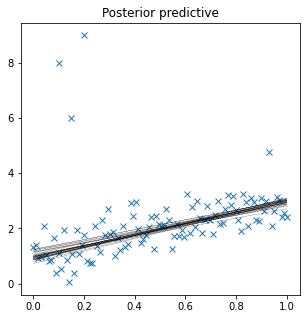

In [47]:
with pm.Model() as model_robust:
    family = pm.glm.families.StudentT(link=pm.glm.families.Identity(),
                                   priors={'nu': 1.5,  # DOF
                                           'lam': pm.Uniform.dist(0, 20)}) # variance
    pm.GLM.from_formula('y ~ x', data_outlier, family=family)
    trace = pm.sample(2000, cores=2)

plt.figure(figsize=(5, 5))
plt.plot(x_out, y_out, 'x')
pm.plot_posterior_predictive_glm(trace)

## Linear Spline 

What is a spline? 
- a spline is a special function defined piecewise by polynomials. 

In the demo below we will try to split a spline connecting two lines to the data generated below. 

In [48]:
size = 100
true_intercept = 1
true_slope = 2
x = np.linspace(0, 2, size)
y = true_intercept + x*x*true_slope + np.random.normal(scale=.5, size=size)
data = {'x': x, 'y': y}

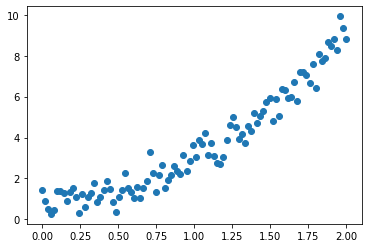

In [49]:
fig,ax = plt.subplots()
ax.scatter(x,y);

In [50]:
with pm.Model() as model_knot:
    knot_x = pm.Uniform('knot_x', x.min(), x.max())
    knot_y = pm.Uniform('knot_y', y.min(), y.max())
    beta1a = pm.Normal('beta1a', mu=0, sd=10)
    beta1b = pm.Normal('beta1b', mu=0, sd=10)
    sigma = pm.HalfNormal('sigma', sd=100)
    
    observed = pm.Normal('observed',
                         mu=pm.math.where( x < knot_x,
                                          knot_y + beta1a*(x - knot_x),
                                          knot_y + beta1b*(x - knot_x)),
                         sd=sigma,
                         observed=y)

In [51]:
n_sample = 5000
with model_knot:
    trace = pm.sample(n_sample)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta1b, beta1a, knot_y, knot_x]
Sampling 2 chains: 100%|██████████| 11000/11000 [01:11<00:00, 154.70draws/s]
The number of effective samples is smaller than 25% for some parameters.


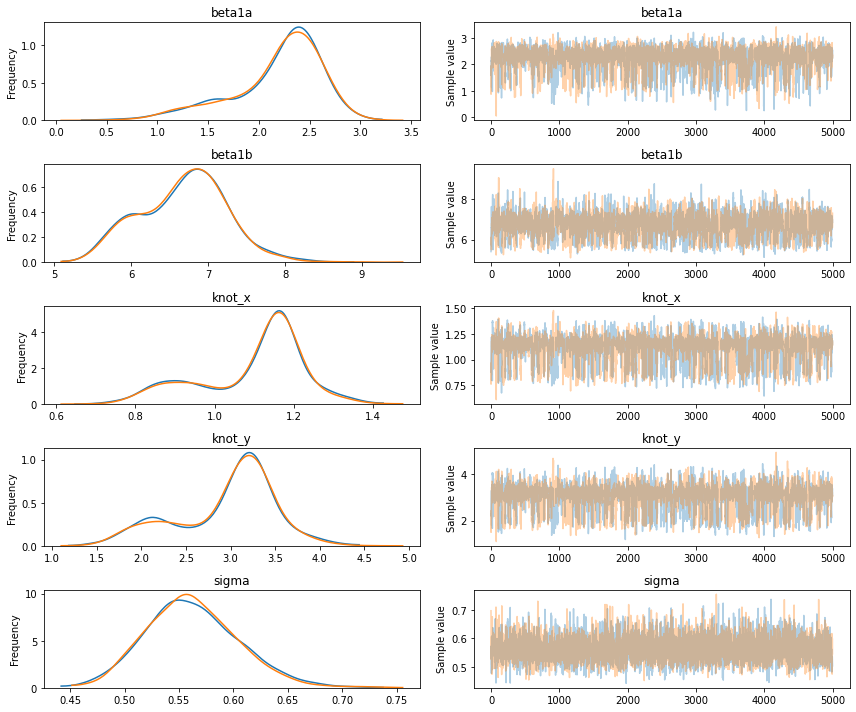

In [52]:
pm.traceplot(trace);

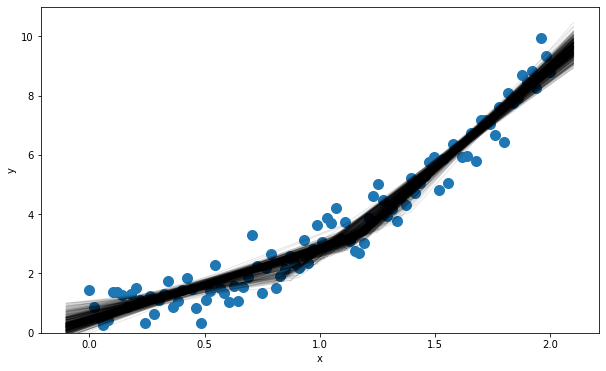

In [53]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x,y, s=100)
ax.set_xlabel('x')
ax.set_ylabel('y')
start, end = ax.get_xlim()
for i in range(0, 5000, 10):
    knot_x = trace[i]['knot_x']
    knot_y = trace[i]['knot_y']
    beta1a = trace[i]['beta1a']
    beta1b = trace[i]['beta1b']

    ax.plot([start, knot_x],
            knot_y + beta1a * (np.array([start, knot_x]) - knot_x),
            c='k', lw=1, alpha=0.1)
    ax.plot([knot_x, end],
            knot_y + beta1b * (np.array([knot_x, end]) - knot_x),
            c='k', lw=1, alpha=0.1)

ax.set_ylim(bottom=0);

### Optional Aside : Hamiltonian Monte Carlo and No-U-Turn Sampling

Here is a brief intro:

#### Hamiltonian Monte Carlo (HMC)

Simulating the dynamics of physical systems is common in the computational sciences.  We can think about what information we would need by thinking through how a pendulum moves.  Based on the position of a pendulum I could calculate the potential energy (from gravity); I could calculate the for the pendulum feels (FYI, $Force = - \nabla V$); I could know the velocity or momomentum of the pendulum at a moment in time.  Using all of this information I could simulate how the pendulum moves over time.  

![](pendulum.jpg)

In order to use dynamic tools to sample probability distributions in statistics, we will assume that the potential energy of our system is -log(probability) and give a random initial momentum to our fictious system. We will then evolve how the fictious system moves over time.  The HMC algorithm becomes

1. Choose an initial momentum for your system
2. Evolve your fictious system over a discrete number of time steps, to obtain an new configuration.
3. Accept or reject based off Metropolis-Hasting Criterion.  

#### Brief Introduction to No-U-Turn Sampling (NUTS)

Issues with HMC:

1. How long do you run the dynamic simulation? How could I know when to stop (think about the pendulum example)? 

<br><br><br><br><br>

![](pendulum_motion.gif)

The idea behing No-U-Turn Sampling (NUTS) is exactly what it says; once you start to do a U-Turn in your dynamics, its time to stop since you will likely resample where you were previously located. Pick a point somewhere along the trajectory as you new trial candidate.  NUTS is used in the python module, pymc3, which was introduced. 